### Model: MobileNetV2
This notebook is an extenstion of notebook "TrainBadeModel". It will use the same transfer learning model but with a data augmented version of the dataset. These two notebooks will be used to compare the predictive effect of data augmentation.

## Import Libraries & Load Data

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from data_loader import load_dir, split_data, create_dataset, data_augmentation

In [12]:
# define 
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size=(224,224)
num_classes=2

In [13]:
# Load images and labels
train_images, train_labels = load_dir(train_dir, classes, max_images, image_size)
test_images, test_labels = load_dir(test_dir, classes, max_images, image_size)

In [4]:
# Print the number of files found
total_files = len(train_images) + len(test_images)
print(f"Found {total_files} files belonging to {len(classes)} classes.")

# Split the training data into train and validation sets
train_images, train_labels, val_images, val_labels = split_data(train_images, train_labels, val_split=0.2)

# Print the number of files used for training and validation
print(f"Using {len(train_images)} files for training.")
print(f"Using {len(val_images)} files for validation.")

Found 200 files belonging to 2 classes.
Using 80 files for training.
Using 80 files for validation.


In [5]:
# Create train and validation datasets
train_ds = create_dataset(train_images, train_labels, batch_size=10)
val_ds = create_dataset(val_images, val_labels, batch_size=10)

test_ds = create_dataset(test_images, test_labels, batch_size=10)

In [6]:
# verify shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)

for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape, labels.shape)

Train batch shape: (10, 224, 224, 3) (10,)
Test batch shape: (10, 224, 224, 3) (10,)


2024-08-07 12:52:01.453020: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-07 12:52:01.475276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Augment Data

In [48]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomBrightness(factor=0.1)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

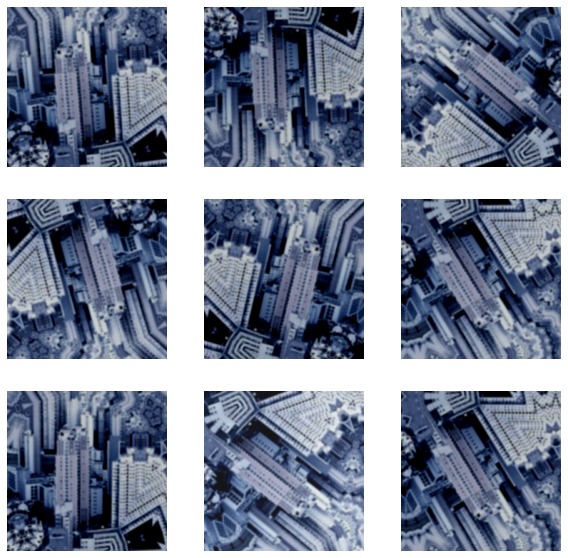

In [49]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [50]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Train Model

In [51]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [52]:
model = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [56]:
epochs = 80

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # changed to updated optimizer API
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - acc: 0.6774 - loss: 0.4464 - val_acc: 0.7250 - val_loss: 0.4900
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - acc: 0.7510 - loss: 0.4279 - val_acc: 0.7250 - val_loss: 0.4852
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - acc: 0.8412 - loss: 0.3505 - val_acc: 0.7625 - val_loss: 0.4733
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - acc: 0.8438 - loss: 0.3535 - val_acc: 0.7375 - val_loss: 0.4770
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - acc: 0.8453 - loss: 0.3892 - val_acc: 0.7250 - val_loss: 0.4858
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - acc: 0.8474 - loss: 0.3262 - val_acc: 0.7250 - val_loss: 0.4868
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - acc: 0.7958 - loss: 0.3874 - val_acc: 0.7250 - val_loss: 0.4681
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - acc: 0.8973 - loss: 0.3481 - val_acc: 0.7375 - val_loss: 0.4594
Epoch 9/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - acc: 0.8450 - loss: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - acc: 0.8907 - loss: 0.2947 - val_acc: 0.8375 - val_loss: 0.3557
Epoch 56/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - acc: 0.9146 - loss: 0.2278 - val_acc: 0.8125 - val_loss: 0.3584
Epoch 57/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - acc: 0.8790 - loss: 0.2571 - val_acc: 0.8375 - val_loss: 0.3528
Epoch 58/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - acc: 0.8635 - loss: 0.2861 - val_acc: 0.8500 - val_loss: 0.3459
Epoch 59/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - acc: 0.8991 - loss: 0.2507 - val_acc: 0.8375 - val_loss: 0.3502
Epoch 60/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - acc: 0.9561 - loss: 0.1696 - val_acc: 0.8375 - val_loss: 0.3513
Epoch 61/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - acc: 0.9239 - loss: 0.3012 - val_acc: 0.8375 - val_loss: 0.3546
Epoch 62/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - acc: 0.8988 - loss: 0.2770 - val_acc: 0.8125 - val_loss: 0.3580
Epoch 63/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - acc: 0.8616 - loss: 0.2

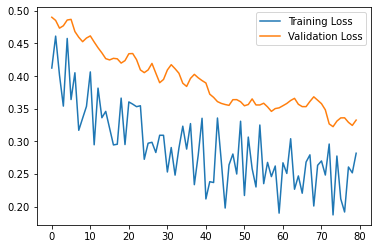

In [57]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

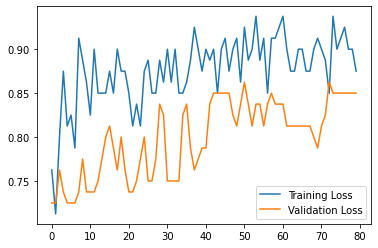

In [58]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [59]:
# save model

model_dir='Models'
os.makedirs(model_dir,exist_ok=True)

model_path=os.path.join(model_dir,'BaseModelAugment.keras')
model.save(model_path)